# Genetic Partitioning

This notebook shows the implementation of the algorithm proposed in [Generalised Circuit Partitioning for Distributed Quantum Computing](https://arxiv.org/abs/2408.01424). 

In [7]:
from qiskit.circuit.library import QFT
from disqco.circuits.cp_fraction import cp_fraction, cz_fraction
from qiskit import transpile
from QASMBench.interface.qiskit import QASMBenchmark
from disqco.graphs.quantum_network import QuantumNetwork


num_qubits = 32

circuit = cp_fraction(num_qubits, num_qubits, fraction=0.5)

# circuit = QFT(num_qubits, do_swaps=False)

num_partitions = 4 # Define the number of partitions or QPUs you will distribute over
depth = circuit.depth()

qpu_size = num_qubits // num_partitions + 1 # Define the number of qubits per QPU. For simplicity, we divide qubits evenly and add one additional space to each for teleportation (an extra space is needed for the teleportation qubit so the algorithmr requires it!)
qpu_sizes = [qpu_size] * num_partitions # Store the number of qubits per QPU in a list

# Create a quantum network with the specified number of qubits and partitions

# If we do not specificy the connectivity, we have all-to-all by default.

quantum_network = QuantumNetwork(qpu_sizes)



basis_gates = ['u', 'cp']

# Transpile the circuit to the basis gates
circuit = transpile(circuit, basis_gates=basis_gates)

print(f'Number of qubits in circuit {circuit.num_qubits}')
print(f'Circuit depth: {circuit.depth()}')

Number of qubits in circuit 32
Circuit depth: 32


The algorithm below uses the same parameters used in the papers for GCP-E. The GCP-S version, which doesn't use gate packing / gate grouping can be accessed by setting gate_packing = False. The multi_process flag can be used to parallelise the genetic algorithm which will speed up large instances.

In [8]:
from disqco.parti.genetic.genetic_algorithm_original import Genetic_Partitioning

genetic_partitioner = Genetic_Partitioning(circuit, qpu_sizes, gate_packing=True)

results = genetic_partitioner.run(pop_size=100,num_generations=100,mutation_rate=0.9, multi_process=True, log_frequency=10, search_method=True,search_number=100)



Current best cut: 138
Current best cut: 127
Current best cut: 125
Current best cut: 124
Current best cut: 124
Current best cut: 124
Current best cut: 124
Current best cut: 124
Current best cut: 124
Current best cut: 124


Currently we are developing a version of the algorithm with some improvements which will be compatible with multilevel partitioning. This can be accessed via the genetic_algorithm_beta file and can be run the same way but is not in full working order. Be careful of importing both of these together as many contained files have the same names and will be overwritten.

In [9]:
from disqco.parti.genetic.genetic_algorithm_beta import Genetic_Partitioning_Beta

genetic_partitioner = Genetic_Partitioning_Beta(circuit, qpu_sizes, multi_process=False, gate_packing=True)

results = genetic_partitioner.run(pop_size=100,num_generations=100,mutation_rate=0.9, multi_process=False, log_frequency=10, search_method=True,search_number=10)


Current best cut: 137
Current best cut: 120
Current best cut: 114
Current best cut: 109
Current best cut: 106
Current best cut: 104
Current best cut: 104
Current best cut: 104
Current best cut: 104
Current best cut: 104


The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz


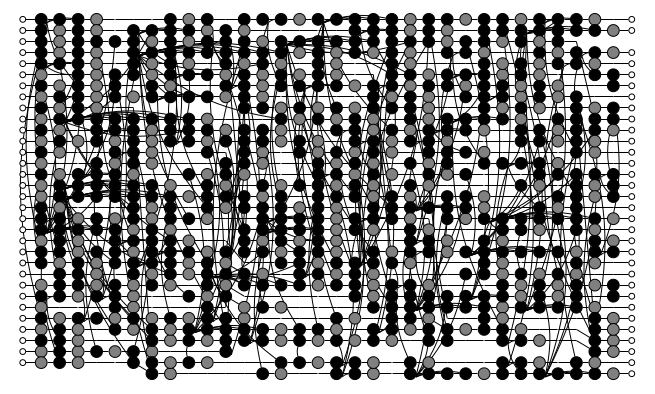

In [12]:
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from disqco.drawing.tikz_drawing import draw_graph_tikz
%load_ext jupyter_tikz

partition = results[0][0][0]

initial_graph = QuantumCircuitHyperGraph(circuit, group_gates=True)

draw_graph_tikz(initial_graph, partition, qpu_sizes)

In [13]:
from disqco.circuit_extraction.circuit_extractor import PartitionedCircuitExtractor



extractor = PartitionedCircuitExtractor(graph=initial_graph, 
                                         partition_assignment=partition, 
                                         qpu_info=qpu_sizes, 
                                         comm_info=[2]*num_partitions)



basic_partitioned_circuit = extractor.extract_partitioned_circuit()

basic_partitioned_circuit_EPR = transpile(basic_partitioned_circuit, basis_gates=['cp','u','EPR'])

print(f"Depth of partitioned circuit: {basic_partitioned_circuit.depth()}")

EPR_count = basic_partitioned_circuit_EPR.count_ops()['EPR']
print(f"EPR count in partitioned circuit: {EPR_count}")



Depth of partitioned circuit: 201
EPR count in partitioned circuit: 104
